### Import

In [1]:
import xml.etree.ElementTree as ET
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

### Read Data

In [2]:
xml_file = "O-A0038-003.xml"
tree = ET.parse(xml_file)
root = tree.getroot()
ns = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}

lon0 = float(root.find('.//cwa:BottomLeftLongitude', ns).text)
lat0 = float(root.find('.//cwa:BottomLeftLatitude', ns).text)

content_text = root.find('.//cwa:Content', ns).text.strip()
values = [float(v) for v in content_text.replace('\n', ',').split(',') if v.strip()]

cols, rows = 67, 120
grid = np.array(values).reshape(rows, cols)

label_grid = np.where(grid == -999.0, 0, 1)
value_grid = np.where(grid == -999.0, np.nan, grid)

lon = np.linspace(lon0, lon0 + (cols - 1) * 0.03, cols)
lat = np.linspace(lat0, lat0 + (rows - 1) * 0.03, rows)

### Drawing Data

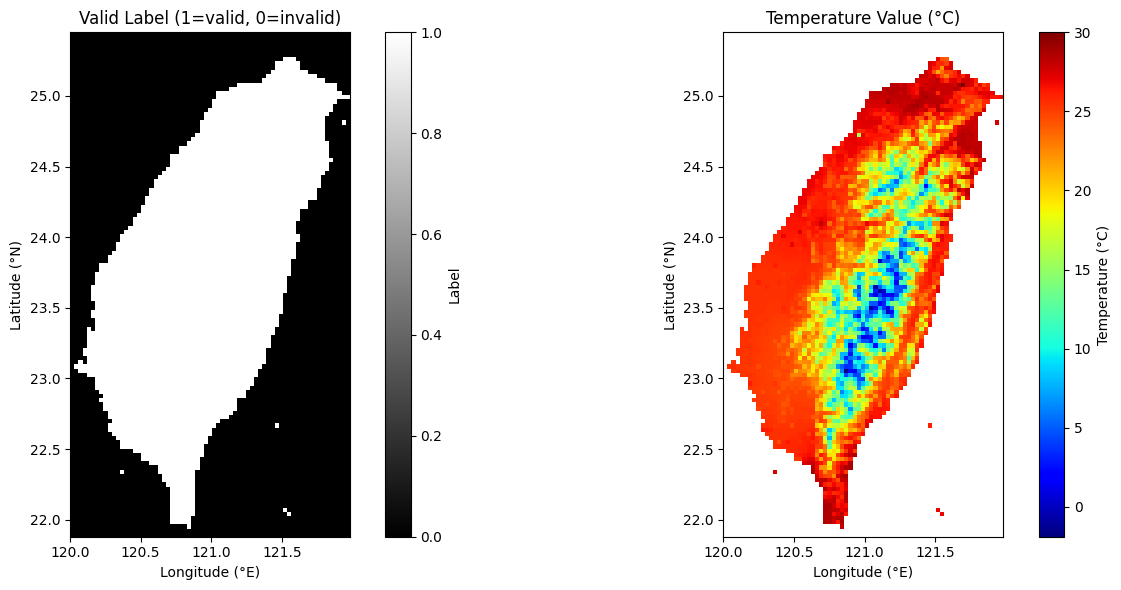

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im1 = axes[0].imshow(label_grid, extent=[lon.min(), lon.max(),
                                        lat.min(), lat.max()],
                     origin='lower', cmap='gray')
axes[0].set_title("Valid Label (1=valid, 0=invalid)")
axes[0].set_xlabel("Longitude (°E)")
axes[0].set_ylabel("Latitude (°N)")
fig.colorbar(im1, ax=axes[0], label="Label")

im2 = axes[1].imshow(value_grid, extent=[lon.min(), lon.max(),
                                        lat.min(), lat.max()],
                     origin='lower', cmap='jet')
axes[1].set_title("Temperature Value (°C)")
axes[1].set_xlabel("Longitude (°E)")
axes[1].set_ylabel("Latitude (°N)")
fig.colorbar(im2, ax=axes[1], label="Temperature (°C)")

plt.tight_layout()
plt.show()


### Make Dataset

In [4]:
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
lon_flat = lon_mesh.flatten()
lat_flat = lat_mesh.flatten()

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()

def norm_coords(lon_vals, lat_vals):
    lon_n = (lon_vals - lon_min) / (lon_max - lon_min)
    lat_n = (lat_vals - lat_min) / (lat_max - lat_min)
    return lon_n, lat_n

lon_norm, lat_norm = norm_coords(lon_flat, lat_flat)
value_flat = grid.flatten()
label_flat = (value_flat != -999.0).astype(float)  # 1=valid, 0=invalid

tensor_cls = torch.tensor(np.column_stack([lon_norm, lat_norm, label_flat]), dtype=torch.float32)
tensor_reg = torch.tensor(np.column_stack([lon_norm[label_flat==1], lat_norm[label_flat==1], value_flat[label_flat==1]]), dtype=torch.float32)

In [5]:
def make_dataset(tensor, batch_size=64, split=0.8):
    X = tensor[:, :2]
    y = tensor[:, -1].unsqueeze(1)
    dataset = TensorDataset(X, y)
    n_train = int(len(dataset) * split)
    n_val = len(dataset) - n_train
    train_ds, val_ds = random_split(dataset, [n_train, n_val])
    return (DataLoader(train_ds, batch_size=batch_size, shuffle=True),
            DataLoader(val_ds, batch_size=batch_size))

train_cls, val_cls = make_dataset(tensor_cls)
train_reg, val_reg = make_dataset(tensor_reg)


### Model setting

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 8), nn.ReLU(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return torch.sigmoid(self.net(x))

class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 32), nn.Tanh(),
            nn.Linear(32, 8), nn.Tanh(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.net(x)
    
class HxModel(nn.Module):
    def __init__(self, classifier, regressor, invalid_value=-999.0, threshold=0.5):
        super().__init__()
        self.classifier = classifier
        self.regressor = regressor
        self.invalid_value = invalid_value
        self.threshold = threshold

    def forward(self, x):
        c_pred = self.classifier(x)
        r_pred = self.regressor(x)
        h_pred = torch.where(c_pred > self.threshold, r_pred, torch.tensor(self.invalid_value, device=x.device))
        return h_pred   


### Training

In [7]:
classifier = Classifier()
opt_c = torch.optim.Adam(classifier.parameters(), lr=1e-3)
loss_fn_c = nn.BCELoss()
train_loss_c, val_loss_c = [], []

for epoch in range(1, 1001):
    classifier.train()
    total = 0
    for X, y in train_cls:
        opt_c.zero_grad()
        pred = classifier(X)
        loss = loss_fn_c(pred, y)
        loss.backward()
        opt_c.step()
        total += loss.item()
    train_loss_c.append(total / len(train_cls))

    classifier.eval()
    with torch.no_grad():
        val_total = 0
        for Xv, yv in val_cls:
            pv = classifier(Xv)
            val_total += loss_fn_c(pv, yv).item()
        val_loss_c.append(val_total / len(val_cls))
    
    if epoch % 50 == 0:
        print(f"[Classifier] Epoch {epoch:03d} | Train={train_loss_c[-1]:.4f} | Val={val_loss_c[-1]:.4f}")

[Classifier] Epoch 050 | Train=0.0658 | Val=0.0482
[Classifier] Epoch 100 | Train=0.0636 | Val=0.0450
[Classifier] Epoch 150 | Train=0.0615 | Val=0.1392
[Classifier] Epoch 200 | Train=0.0660 | Val=0.0491
[Classifier] Epoch 250 | Train=0.0504 | Val=0.0458
[Classifier] Epoch 300 | Train=0.0495 | Val=0.0351
[Classifier] Epoch 350 | Train=0.0448 | Val=0.0354
[Classifier] Epoch 400 | Train=0.0512 | Val=0.0344
[Classifier] Epoch 450 | Train=0.0400 | Val=0.0282
[Classifier] Epoch 500 | Train=0.0424 | Val=0.0393
[Classifier] Epoch 550 | Train=0.0405 | Val=0.0339
[Classifier] Epoch 600 | Train=0.0354 | Val=0.0391
[Classifier] Epoch 650 | Train=0.0370 | Val=0.0430
[Classifier] Epoch 700 | Train=0.0343 | Val=0.0327
[Classifier] Epoch 750 | Train=0.0339 | Val=0.0583
[Classifier] Epoch 800 | Train=0.0362 | Val=0.0333
[Classifier] Epoch 850 | Train=0.0369 | Val=0.0314
[Classifier] Epoch 900 | Train=0.0368 | Val=0.0322
[Classifier] Epoch 950 | Train=0.0385 | Val=0.0342
[Classifier] Epoch 1000 | Train

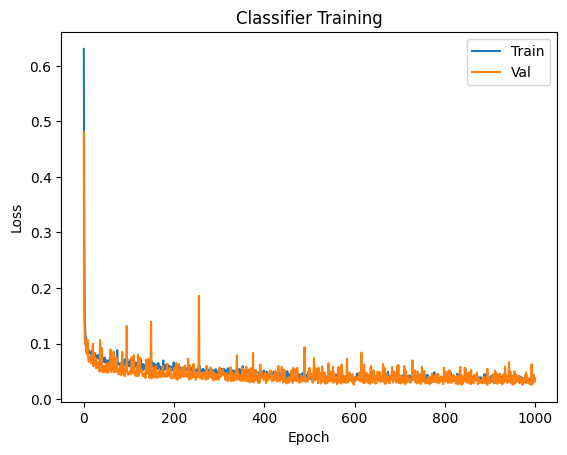

In [8]:
plt.figure()
plt.plot(train_loss_c, label='Train')
plt.plot(val_loss_c, label='Val')
plt.title("Classifier Training")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.savefig('Classifier loss.png', dpi=300)
plt.legend(); plt.show()

In [9]:
regressor = Regressor()
opt_r = torch.optim.Adam(regressor.parameters(), lr=1e-3)
loss_fn_r = nn.MSELoss()

train_loss_r, val_loss_r = [], []

for epoch in range(1, 3001):
    regressor.train()
    total = 0
    for X, y in train_reg:
        opt_r.zero_grad()
        pred = regressor(X)
        loss = loss_fn_r(pred, y)
        loss.backward()
        opt_r.step()
        total += loss.item()
    train_loss_r.append(total / len(train_reg))

    regressor.eval()
    with torch.no_grad():
        val_total = 0
        for Xv, yv in val_reg:
            pv = regressor(Xv)
            val_total += loss_fn_r(pv, yv).item()
        val_loss_r.append(val_total / len(val_reg))
    
    if epoch % 50 == 0:
        print(f"[Regressor] Epoch {epoch:03d} | Train={train_loss_r[-1]:.4f} | Val={val_loss_r[-1]:.4f}")

[Regressor] Epoch 050 | Train=62.5579 | Val=62.8544
[Regressor] Epoch 100 | Train=37.1220 | Val=41.0861
[Regressor] Epoch 150 | Train=36.8853 | Val=41.1517
[Regressor] Epoch 200 | Train=36.8401 | Val=41.1463
[Regressor] Epoch 250 | Train=36.8426 | Val=41.1528
[Regressor] Epoch 300 | Train=12.8480 | Val=12.1145
[Regressor] Epoch 350 | Train=7.8937 | Val=8.4130
[Regressor] Epoch 400 | Train=7.1861 | Val=8.8091
[Regressor] Epoch 450 | Train=6.7669 | Val=8.7604
[Regressor] Epoch 500 | Train=6.5782 | Val=8.4352
[Regressor] Epoch 550 | Train=6.4971 | Val=8.5129
[Regressor] Epoch 600 | Train=6.3179 | Val=8.2674
[Regressor] Epoch 650 | Train=6.3288 | Val=8.1298
[Regressor] Epoch 700 | Train=6.1313 | Val=8.2564
[Regressor] Epoch 750 | Train=6.0541 | Val=8.0367
[Regressor] Epoch 800 | Train=5.9981 | Val=8.2469
[Regressor] Epoch 850 | Train=5.8946 | Val=8.4375
[Regressor] Epoch 900 | Train=5.7802 | Val=8.0757
[Regressor] Epoch 950 | Train=5.6919 | Val=7.9895
[Regressor] Epoch 1000 | Train=5.7345 

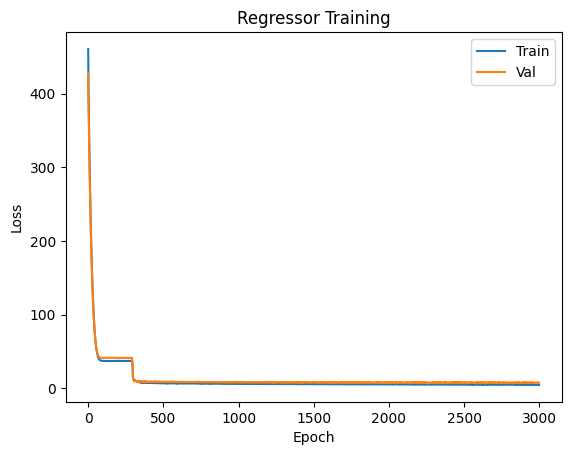

In [10]:
plt.figure()
plt.plot(train_loss_r, label='Train')
plt.plot(val_loss_r, label='Val')
plt.title("Regressor Training")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.savefig('Regressor loss.png', dpi=300)
plt.legend(); plt.show()

In [11]:
piecewise_model = HxModel(classifier, regressor)

test_points = torch.tensor(np.column_stack([lon_norm, lat_norm]), dtype=torch.float32)

piecewise_model.eval()
with torch.no_grad():
    h_pred_grid = piecewise_model(test_points).reshape(rows, cols).numpy()

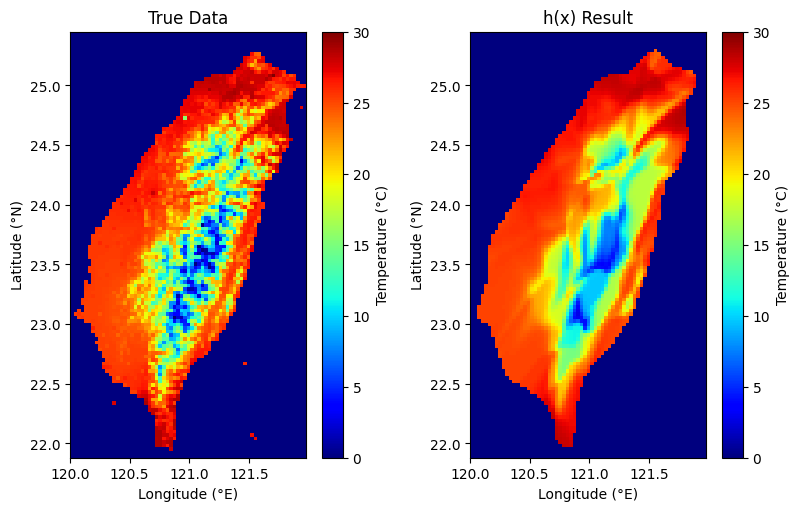

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)

im0 = axes[0].imshow(grid, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                     origin='lower', cmap='jet', vmin=0, vmax=30)
axes[0].set_title("True Data")
axes[0].set_xlabel("Longitude (°E)")
axes[0].set_ylabel("Latitude (°N)")
fig.colorbar(im0, ax=axes[0], label="Temperature (°C)")

im2 = axes[1].imshow(h_pred_grid, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                     origin='lower', cmap='jet', vmin=0, vmax=30)
axes[1].set_title("h(x) Result")
axes[1].set_xlabel("Longitude (°E)")
axes[1].set_ylabel("Latitude (°N)")
fig.colorbar(im2, ax=axes[1], label="Temperature (°C)")

plt.savefig('Result.png', dpi=300)
plt.show()
